# Time Series Forecasting - 
**Data Source: Citibike rentals in New York City**

This series uses Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will illustrate some common forecasting issues due to new stations being introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at: 
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`


In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'vertexaiproject-454121'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-data'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

viz_limit = 12

packages:

In [3]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)

### Create BigQuery Dataset
Create a BigQuery Dataset within this project 

In [5]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #Multi-region is REGION[0:2]
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [6]:
ds.dataset_id

'applied_forecasting'

In [7]:
ds.full_dataset_id

'vertexaiproject-454121:applied_forecasting'

List BigQuery datasets in the project:

In [8]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
dataset_name
fraud


### Review Source Data
Stored in BigQuery Public Datasets

In [9]:
query = f"""
    SELECT * 
    FROM `bigquery-public-data.new_york.citibike_trips`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,133,2016-06-14 14:48:17+00:00,2016-06-14 14:50:31+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,22312,Subscriber,1998,male
1,1620,2016-08-26 10:04:09+00:00,2016-08-26 10:31:09+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,16311,Subscriber,1993,male
2,134,2014-03-13 18:08:00+00:00,2014-03-13 18:10:14+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,16536,Subscriber,1966,female
3,179,2016-04-02 17:24:11+00:00,2016-04-02 17:27:11+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,17825,Subscriber,1983,male
4,720,2014-08-04 11:28:18+00:00,2014-08-04 11:40:18+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,21500,Subscriber,1954,male


In [10]:
query = f"""
    SELECT * 
    FROM `bigquery-public-data.new_york.citibike_stations`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,495,W 47 St & 10 Ave,6824.07,40.762699,-73.993012,71,"KEY, CREDITCARD",0,False,0,0,0,0,True,True,True,False,1970-01-02 00:00:00+00:00
1,3171,Amsterdam Ave & W 82 St,7360.10,40.785247,-73.976673,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
2,3603,31 Ave & 30 St,6857.09,40.764700,-73.924031,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
3,3733,Avenue C & E 18 St,5769.04,40.730563,-73.973984,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
4,3792,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,70,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00


Review miss-matches in station names between the two source tables:

In [11]:
query = """
    WITH
        STATIONS AS (
            SELECT distinct name as stations
            FROM `bigquery-public-data.new_york.citibike_stations`
            WHERE name LIKE '%Central Park%'
        ),
        TRIPS AS (
            SELECT distinct start_station_name as trips
            FROM `bigquery-public-data.new_york.citibike_trips`
            WHERE start_station_name LIKE '%Central Park%'   
        )
    SELECT *
    FROM STATIONS a
    FULL JOIN TRIPS b
    on a.stations = b.trips
"""
bq.query(query).to_dataframe()

,stations,trips
0,W 106 St & Central Park West,W 106 St & Central Park West
1,Central Park North & Adam Clayton Powell Blvd,Central Park North & Adam Clayton Powell Blvd
2,Central Park West & W 85 St,Central Park West & W 85 St
3,None,Central Park West & W 100 St
4,Central Park West & W 76 St,Central Park West & W 76 St
5,W 82 St & Central Park West,W 82 St & Central Park West
6,None,Central Park West & W 102 St
7,Central Park W & W 97 St,None
8,Central Park W & W 91 St,None
9,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S


### Create a Source Table or View
It is common to need to combine multiple sources together to bring together all the data needed for forecasting.  Here, multiple source tables are referenced to create a combined forecasting source table.

The goal is one row per time point for each time series.  The means aggregating the transaction to a demand signal for each time series and each time point (day, month, quarter, ...).

If all of the data needed for forecasting is already prepared then a statement like this might not be needed.  Adapting this code to your situation it could be a simple as:

```SQL
CREATE OR REPLACE VIEW `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
SELECT *
FROM {BQ_SOURCE}
```

In [12]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
        FROM `bigquery-public-data.new_york.citibike_trips`
        WHERE start_station_name LIKE '%Central Park%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `bigquery-public-data.new_york.citibike_stations`
        WHERE name LIKE '%Central Park%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

2.359

In [13]:
print(f'Review The Source Data in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_source&pli=1')

Review The Source Data in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121&ws=!1m5!1m4!4m3!1svertexaiproject-454121!2sapplied_forecasting!3sforecasting-data_source&pli=1


### Prepare Data for Forecasting

In [14]:
# CUSTOMIZE THIS CELL
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

Quick Summary of Series with totals and date ranges for each series:

In [15]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


Visualize each series date/time range:

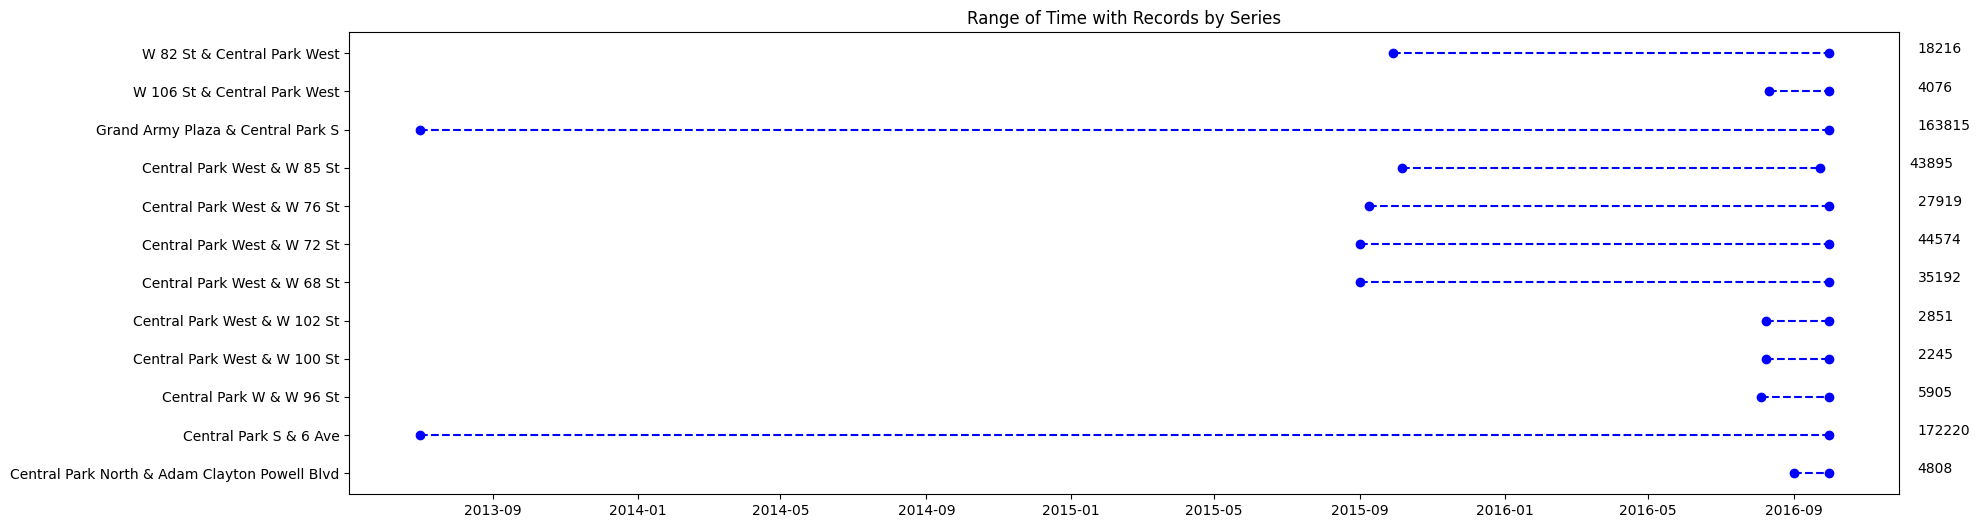

In [16]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

Overlay the dates with data onto the plot to understand any gaps in data for the series:

In [17]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq.query(query).to_dataframe()

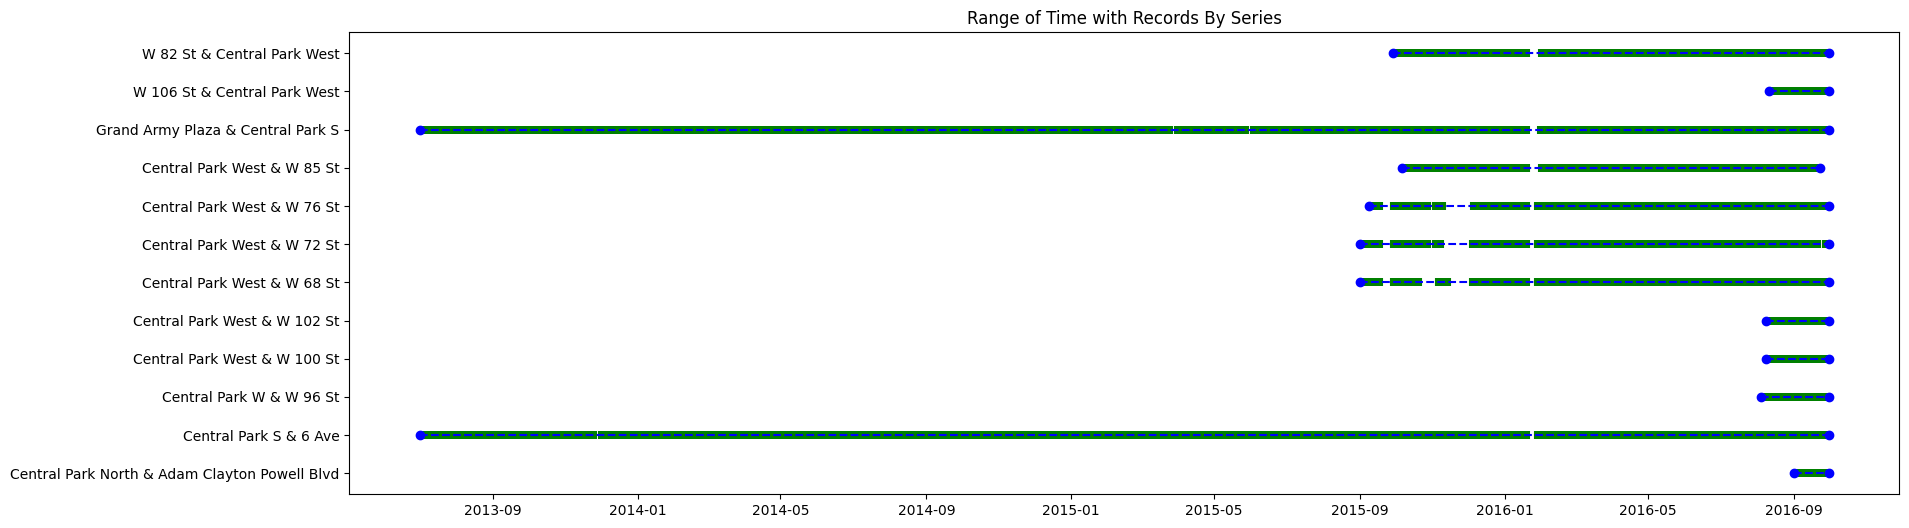

In [18]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Propose Train/Validation/Test Splits by Date Range

Get key dates from the series data while setting the forcast horizon:

**Forecasting Parameters**:
- `FORECAST_GRANULARITY` is the frequency of measurment like MINUTE, HOUR, DAY, WEEK, MONTH, YEAR
    - The data was summarized at the DAY level in the data preparation notebook
    - This is the amount of time between measurments - rows 
    - For a different granularity, you may need to summarize the demand signal as a `SUM`, `MIN`, `MAX`, or `AVERAGE` for different time components.
    - specification of granularity differs by method:
        - BigQuery ML: PER_MINUTE, HOURLY, DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY
        - Prophet (including Vertex Pre-Built Pipelines): minute, hour, day, week, month, or year
        - Vertex AI AutoML: minute, hour, day, week, month, year 
    - A very helpful BigQuery function for extracting components of times and dates is the `EXTRACT` function:
        - [EXTRACT as a date function](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [EXTRACT as a time function](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [EXTRACT as a datetime function](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract).
- `FORECAST_TEST_LENGTH` is the number of rows allocated to the test region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'TEST'` values for each time series in `SERIES_COLUMMN`.
- `FORCAST_VALIDATE_LENGTH` is the number of rows allocated to the validation region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'VALIDATE'` values for each time series in `SERIES_COLUMN`.
- `FORECAST_HORIZON_LENGTH` is the number of rows to forecast into the future beyond the test region
    - This is in the units of `FORECAST_GRANULARITY`
    - This needs to be set as an input to the forecast method

In [19]:
# CUSTOMIZE
FORECAST_GRANULARITY = 'DAY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

In [20]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {FORECAST_TEST_LENGTH + FORECAST_VALIDATE_LENGTH}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {FORECAST_TEST_LENGTH}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Visualize each series date/time range with proposed data segments from key dates:

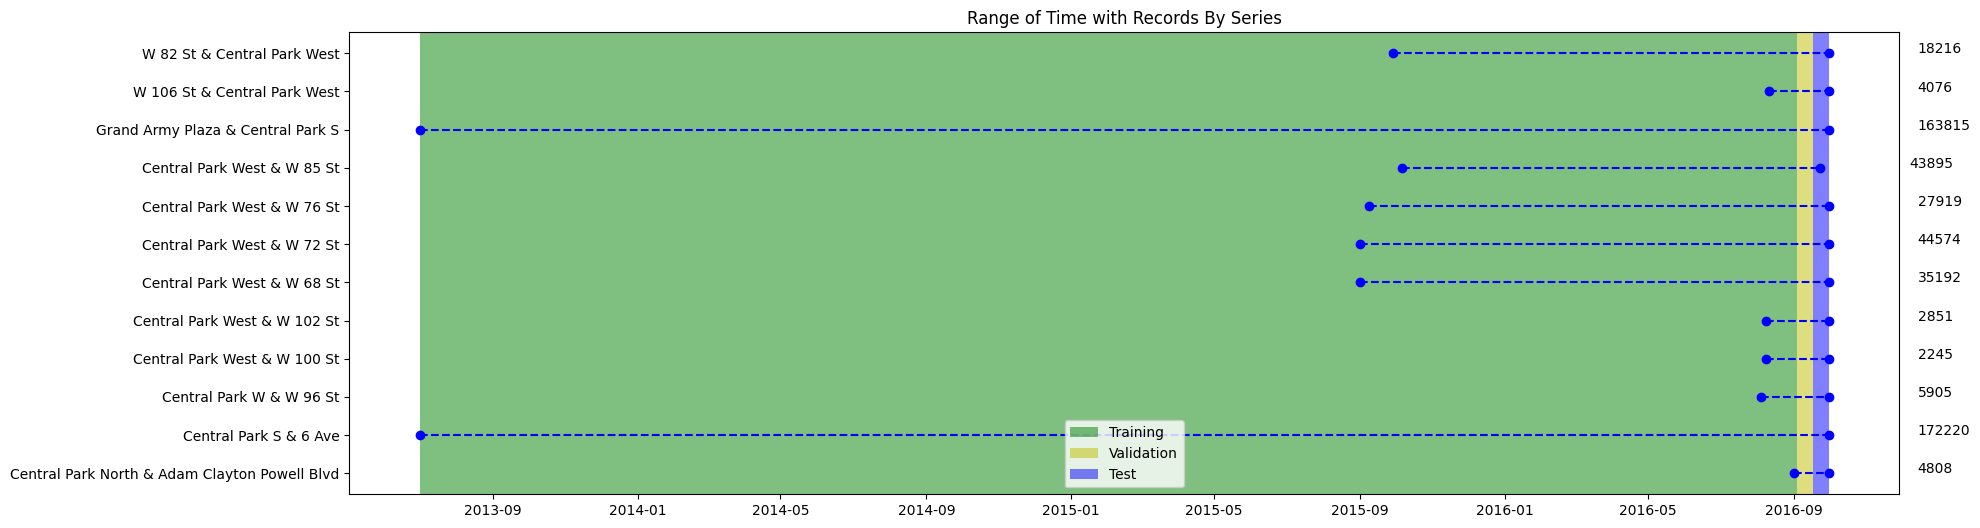

In [21]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting
Put it all together!

In [22]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {FORECAST_TEST_LENGTH} {FORECAST_GRANULARITY}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {FORECAST_TEST_LENGTH} + {FORECAST_VALIDATE_LENGTH} {FORECAST_GRANULARITY}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS {SPLIT_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.647

In [23]:
print(f'Review The Prepped Data in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_prepped&pli=1')

Review The Prepped Data in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121&ws=!1m5!1m4!4m3!1svertexaiproject-454121!2sapplied_forecasting!3sforecasting-data_prepped&pli=1


## Review Forecasting Data

In [24]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF({SPLIT_COLUMN} = 'TRAIN') as TRAIN,
        COUNTIF({SPLIT_COLUMN} = 'VALIDATE') as VALIDATE,
        COUNTIF({SPLIT_COLUMN} = 'TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,num_trips
0,Central Park North & Adam Clayton Powell Blvd,2,14,14,4808
1,Central Park S & 6 Ave,1149,14,14,172220
2,Central Park W & W 96 St,30,14,14,5905
3,Central Park West & W 100 St,26,14,14,2245
4,Central Park West & W 102 St,26,14,14,2851
5,Central Park West & W 68 St,331,14,14,35192
6,Central Park West & W 72 St,334,14,13,44574
7,Central Park West & W 76 St,327,14,14,27919
8,Central Park West & W 85 St,324,14,7,43895
9,Grand Army Plaza & Central Park S,1152,14,13,163815


Totals by data split:

In [25]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: Int64

Overall total:

In [26]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

np.int64(4382)

Visualize days of data available for forecasting at each series:

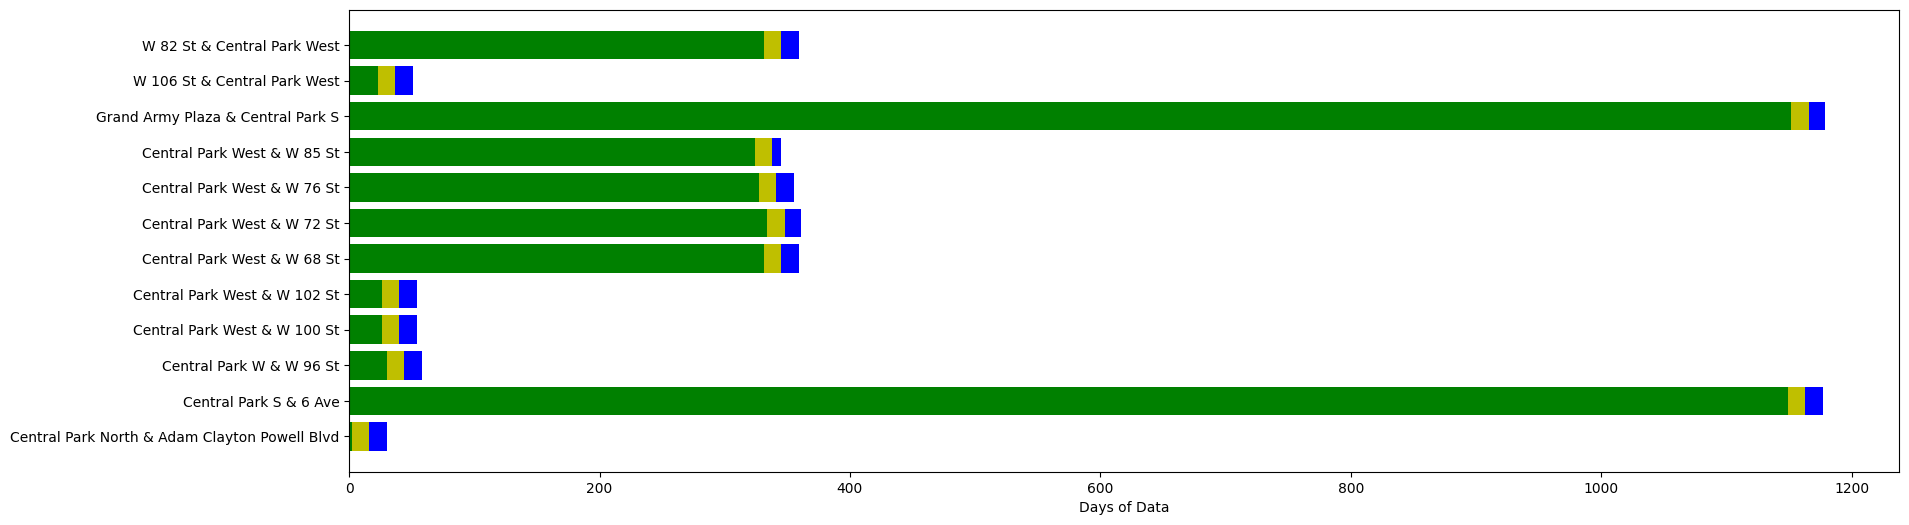

In [27]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

## Validation Check: Extract dates for splits from source

In [28]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


## Validation Check: Duplicate Dates in Series?
Are there any series with data for duplicate dates?

In [29]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq.query(query).to_dataframe()

,start_station_name,starttime,records


## Time Series Review

In [30]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series

Create an interactive chart for review individual time series (bike stations) and scrolling through the time range by using [Plotly](https://plotly.com/python/):

In [31]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

**Example Visual**

The visual above is dynamic with selectable ranges for the timeframe and a drop down to select individual time series.  Load this notebook in a view like Jupyter or VSCode to interact with it.  A static version is displayed below as an example:

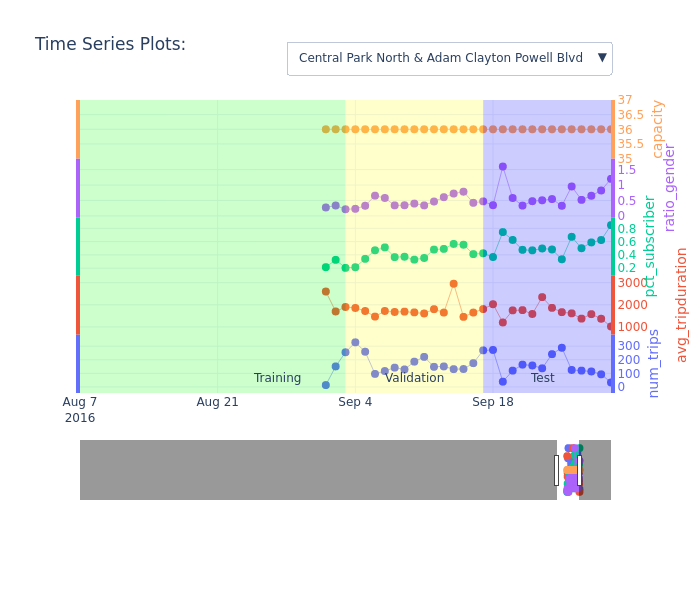

In [32]:
fig.show('png')

In [33]:
EXPERIMENT = 'bqml-arimaplusxreg'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12


from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

In [34]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAILY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE


In [35]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates



,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


In [36]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()


In [37]:
chosen_station = 'Central Park S & 6 Ave'
rawSeries = rawSeries[rawSeries[SERIES_COLUMN]==chosen_station]

In [38]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)
    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()


A Snapshot of the interactive plot:


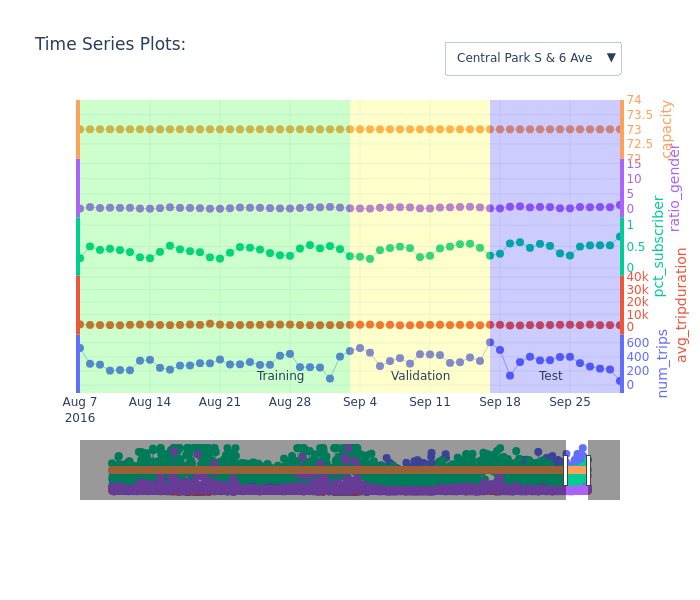

In [39]:
print('A Snapshot of the interactive plot:')
fig.show('png')


In [40]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       #time_series_id_col = '{SERIES_COLUMN}',
       data_frequency = '{FORECAST_GRANULARITY}',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = {FORECAST_HORIZON_LENGTH} + {FORECAST_TEST_LENGTH}
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE {SPLIT_COLUMN} in ('TRAIN','VALIDATE')
        AND {SERIES_COLUMN} = '{chosen_station}'
"""
print(query)



    CREATE OR REPLACE MODEL `vertexaiproject-454121.applied_forecasting.forecasting-data_prepped_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = 'starttime',
       time_series_data_col = 'num_trips',
       #time_series_id_col = 'start_station_name',
       data_frequency = 'DAILY',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = 14 + 14
      ) AS
    SELECT starttime, num_trips,
        avg_tripduration, pct_subscriber, ratio_gender, capacity
    FROM `vertexaiproject-454121.applied_forecasting.forecasting-data_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND start_station_name = 'Central Park S & 6 Ave'



In [41]:
job = bq.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

print(f'Review The Model in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_arimaplusxreg&pli=1')


DONE 19.457
Review The Model in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=vertexaiproject-454121&ws=!1m5!1m4!5m3!1svertexaiproject-454121!2sapplied_forecasting!3sforecasting-data_prepped_arimaplusxreg&pli=1


In [42]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
coefficients = bq.query(query).to_dataframe()
coefficients


,ar_coefficients,ma_coefficients,intercept_or_drift,processed_input,weight,category_weights
0,[],[],NaN,avg_tripduration,-0.001514,[]
1,[],[],NaN,pct_subscriber,-302.167414,[]
2,[],[],NaN,ratio_gender,2.385852,[]
3,[],[],NaN,capacity,25.285775,[]
4,[],[],NaN,__INTERCEPT__,-1724.433226,[]
5,[],"[-0.6885407234910769, -0.40916916413577, 0.703...",0.087799,None,NaN,[]


In [43]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()


,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,num_trips,1.000,555.000000,144.153912,128.000000,112.409702,<NA>,0,<NA>
1,starttime,NaN,NaN,NaN,NaN,NaN,1163,0,<NA>
2,avg_tripduration,336.625,34597.615385,1918.560216,1832.565517,1334.905339,<NA>,0,<NA>
3,pct_subscriber,0.000,1.000000,0.497785,0.466667,0.214707,<NA>,0,<NA>
4,ratio_gender,0.000,14.000000,0.908012,0.567568,1.329083,<NA>,26,<NA>


In [44]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

,training_run,iteration,duration_ms
0,0,0,1585


In [45]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        ),
        STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics


,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,83.9561,12677.33045,112.593652,36.437686,31.24371


In [46]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT(FALSE as show_all_candidate_models))
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,0,1,5,True,-5781.139502,11576.279005,1109.243709,"[WEEKLY, YEARLY]",True,True,False,


In [47]:
query = f"""
    SELECT *
    FROM ML.HOLIDAY_INFO(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
holiday_info = bq.query(query).to_dataframe()
holiday_info


,region,holiday_name,primary_date,preholiday_days,postholiday_days
0,GLOBAL,AllSaintsDay-Halloween,2000-10-31,1,1
1,GLOBAL,AllSaintsDay-Halloween,2001-10-31,1,1
2,GLOBAL,AllSaintsDay-Halloween,2002-10-31,1,1
3,GLOBAL,AllSaintsDay-Halloween,2003-10-31,1,1
4,GLOBAL,AllSaintsDay-Halloween,2004-10-31,1,1
...,...,...,...,...,...
1901,US,VeteranDay,2026-11-11,1,1
1902,US,VeteranDay,2027-11-11,1,1
1903,US,VeteranDay,2028-11-11,1,1
1904,US,VeteranDay,2029-11-11,1,1


In [48]:
query = f"""
    SELECT *
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        )
        )
"""
forecast = bq.query(query).to_dataframe()
forecast

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2016-09-17 00:00:00+00:00,359.108875,33.305317,0.95,293.948418,424.269332
1,2016-09-18 00:00:00+00:00,492.313739,34.883357,0.95,424.065912,560.561566
2,2016-09-19 00:00:00+00:00,333.527815,35.034823,0.95,264.983652,402.071977
3,2016-09-20 00:00:00+00:00,166.268431,40.421154,0.95,87.186138,245.350725
4,2016-09-21 00:00:00+00:00,250.371314,48.236057,0.95,155.999490,344.743138
5,2016-09-22 00:00:00+00:00,262.645345,48.280443,0.95,168.186681,357.104009
6,2016-09-23 00:00:00+00:00,280.352952,48.324789,0.95,185.807528,374.898376
7,2016-09-24 00:00:00+00:00,326.100022,48.369094,0.95,231.467918,420.732127
8,2016-09-25 00:00:00+00:00,383.062154,48.413358,0.95,288.343448,477.780859
9,2016-09-26 00:00:00+00:00,306.364521,48.457582,0.95,211.559293,401.169749


In [49]:
query = f"""
    SELECT '{chosen_station}' as {SERIES_COLUMN}, *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({FORECAST_HORIZON_LENGTH + FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SERIES_COLUMN} = '{chosen_station}'
        )
        )
    ORDER BY {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()
explain.tail()


,start_station_name,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,...,holiday_effect_Halloween,holiday_effect_MardiGras,holiday_effect_US_ColumbusDay,holiday_effect_US_ElectionDay,attribution_avg_tripduration,attribution_pct_subscriber,attribution_ratio_gender,attribution_capacity,attribution___INTERCEPT__,starttime
1197,Central Park S & 6 Ave,2016-10-10 00:00:00+00:00,forecast,342.617766,342.617766,49.072531,0.95,246.609417,438.626116,273.152363,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1845.861568,-1724.433226,2016-10-10
1198,Central Park S & 6 Ave,2016-10-11 00:00:00+00:00,forecast,324.312326,324.312326,49.116161,0.95,228.218616,420.406036,273.240162,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1845.861568,-1724.433226,2016-10-11
1199,Central Park S & 6 Ave,2016-10-12 00:00:00+00:00,forecast,280.494110,280.494110,49.159752,0.95,184.315115,376.673106,273.327960,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1845.861568,-1724.433226,2016-10-12
1200,Central Park S & 6 Ave,2016-10-13 00:00:00+00:00,forecast,233.236731,233.236731,49.203305,0.95,136.972526,329.500936,273.415759,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1845.861568,-1724.433226,2016-10-13
1201,Central Park S & 6 Ave,2016-10-14 00:00:00+00:00,forecast,274.001882,274.001882,49.246820,0.95,177.652543,370.351221,273.503558,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1845.861568,-1724.433226,2016-10-14


In [50]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast prediction funnel to test and horizon: lower
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    name = f'Lower Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast prediction funnel to test and horizon: upper
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    name = f'Upper Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    fillcolor = 'rgba(0,128,0,0.5)',
                    fill = 'tonexty',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    name = f'Forecast: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 3 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

/var/tmp/ipykernel_3287/2160216593.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



A Snapshot of the interactive plot:


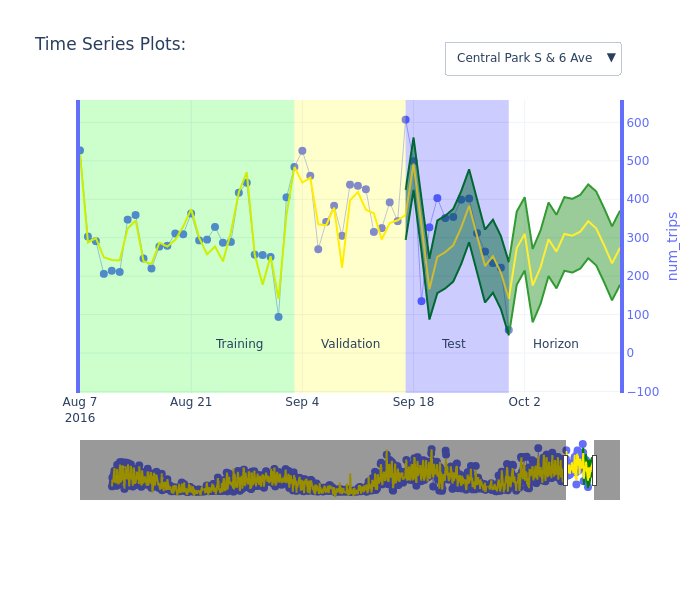

In [51]:
print('A Snapshot of the interactive plot:')
fig.show('png')

In [52]:
query = f"""
    WITH    
        FORECAST AS (
            SELECT
                '{chosen_station}' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE {SPLIT_COLUMN} = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST' AND {SERIES_COLUMN} = '{chosen_station}'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)


,start_station_name,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,Central Park S & 6 Ave,forecast,0.364377,83.9561,0.257252,12677.33045,112.593652,0.345001


In [53]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                '{chosen_station}' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,forecast,0.364377,83.9561,0.257252,12677.33045,112.593652,0.345001


In [54]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg')
#bq.delete_model(model)